In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We manually cleaned and split the dataset into sentences

The code in hear is a collections of scripts from [Abhishek Thakur's GitHub](https://github.com/abhishekkrthakur/bert-entity-extraction)

And from the Transformers library and the Trainer API

In [ ]:
!pip install transformers==3.2.0
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.0MB 14.7MB/s 
     |████████████████████████████████| 1.1MB 18.6MB/s 
     |████████████████████████████████| 890kB 52.4MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b7d50e5c0797b613ecee098a2e12d7c64d9add6121cfc1409221f2e40616880f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 112kB 13.2MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp36-none-any.whl size=113325 sha256=8ca544f68c864e0ad8ac32383821545c6cb5c9a14d8aac6a777ea49960dde623
  Stored in directory: /root/.cache/pip/wheels/10/b8/f5/b7c1a50e6efb83544844f165a9b134afe7292585465e29b61d
Successfully built pyarabic
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=1

#Reading Data

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/drive/My Drive/ANERcorp-CamelLabSplits.zip"

Archive:  /content/drive/My Drive/ANERcorp-CamelLabSplits.zip
replace __MACOSX/._ANERcorp-CamelLabSplits? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ANERcorp-CamelLabSplits/ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/ANERcorp-CamelLabSplits/._ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace __MACOSX/ANERcorp-CamelLabSplits/._ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace __MACOSX/ANERcorp-CamelLabSplits/._ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace __MACOSX/ANERcorp-CamelLabSplits/._ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace __MACOSX/ANERcorp-CamelLabSplits/._ANERCorp_Benajiba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: nn
replace ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt? [y]es, [n]o, [A]ll, [N]one, [r]

In [ ]:
!head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

فرانكفورت B-LOC
(د O
ب O
أ) O
أعلن O
اتحاد B-ORG
صناعة I-ORG
السيارات I-ORG
في O
ألمانيا B-LOC
امس O
الاول O
أن O
شركات O
صناعة O
السيارات O
في O
ألمانيا B-LOC
تواجه O
عاما O
صعبا O
في O
ظل O
ركود O
السوق O
الداخلية O
والصادرات O
وهي O
تسعي O
لان O
يبلغ O
الانتاج O
حوالي O
خمسة O
ملايين O
سيارة O
في O
عام O
2002 O
. O

وقال O
رئيس O
الاتحاد O
برند B-PERS
جوتشولك I-PERS
عند O
إعلان O
آخر O
تقرير O
سنوي O
للاتحاد O
إن O
مستقبل O
السوق O
مازال O
يفتقر O
إلي O
الخطوط O
الواضحة O
. O

وعلي O
الرغم O
من O
أنه O
قال O
أنه O
يتوقع O
أن O
تظل O
صادرات O
السيارات O
عند O
مستوي O
مرتفع O
هذا O
العام O
فإنه O
يبدو O
من O
غير O
المحتمل O
أن O
تصل O
إلي O
مستوي O
سجل O
نموها O
عام O
2001 O
عندما O
زادت O
صادرات O
سيارات O
الركاب O
بنسبة O
ستة O
في O
المائة O


In [ ]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line=='\n':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [ ]:
ANERCorp_path = './ANERcorp-CamelLabSplits/'
data_train = read_ANERcorp(ANERCorp_path+'ANERCorp_CamelLab_train.txt')
data_test = read_ANERcorp(ANERCorp_path+'ANERCorp_CamelLab_test.txt')

In [ ]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 21633, 'B-PERS': 858, 'B-LOC': 668, 'I-PERS': 641, 'B-ORG': 450, 'I-ORG': 275, 'B-MISC': 235, 'I-MISC': 165, 'I-LOC': 83})
Counter({'O': 111921, 'B-LOC': 3776, 'B-PERS': 2721, 'I-PERS': 2205, 'B-ORG': 1576, 'I-ORG': 1115, 'B-MISC': 888, 'I-LOC': 525, 'I-MISC': 375})


In [ ]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['B-LOC', 'O', 'B-PERS', 'I-PERS', 'B-ORG', 'I-LOC', 'I-ORG', 'B-MISC', 'I-MISC']


Training Sentence Lengths: 


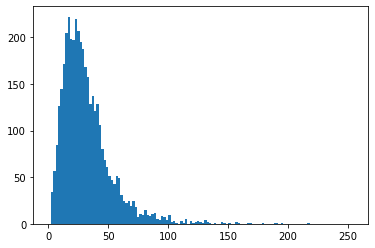

1
Testing Sentence Lengths: 


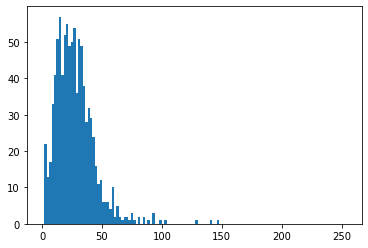

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#Model Files

In [ ]:
from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess_arabert import preprocess, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from farasa.segmenter import FarasaSegmenter

In [ ]:
MAX_SEQ_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 3e-5
WARMUP_RATIO = 0.15
MAX_GRAD_NORM = 1.0

In [ ]:
MAX_SEQ_LEN = 320
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0

#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv01'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)


is_arabertv1=False
farasa_segmenter = None
if BASE_MODEL_PATH == 'aubmindlab/bert-base-arabert':
  is_arabertv1=True
  farasa_segmenter = FarasaSegmenter(interactive=True)

In [ ]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


In [ ]:
# check if the test_dataset is fully covered
if is_arabertv1:
  tokenized_data = [TOKENIZER.tokenize(preprocess(" ".join(sentence[0]),is_arabertv1,farasa_segmenter,True)) for sentence in data_test]
  plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
  plt.show()
  print(sum([len(x) > 256 for x in tokenized_data]))

In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, is_arabertv1=False, farasa_segmenter=None):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.is_arabertv1 = is_arabertv1
    if self.is_arabertv1:
      assert farasa_segmenter is not None
    self.farasa_segmenter = farasa_segmenter
    
    self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):

      if self.is_arabertv1:
        clean_word = preprocess(
          word,
          do_farasa_tokenization=True,
          farasa=self.farasa_segmenter,
          use_farasapy=True
          )
      else:
        clean_word = preprocess(word, do_farasa_tokenization=False)        
      
      word_tokens = TOKENIZER.tokenize(clean_word)
      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    segment_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    segment_ids = [0] + segment_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    input_mask += [0] * padding_length
    segment_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(input_mask) == MAX_SEQ_LEN
    assert len(segment_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("input_mask:", " ".join([str(x) for x in input_mask]))
    #   print("segment_ids:", " ".join([str(x) for x in segment_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'input_mask' : torch.tensor(input_mask, dtype=torch.long),
        'segment_ids' : torch.tensor(segment_ids, dtype=torch.long),
        'label_ids' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [ ]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
 
    def forward(self, input_ids, input_mask, segment_ids, label_ids):
        o1, _ = self.bert(input_ids, attention_mask=input_mask, token_type_ids=segment_ids)
        bo_tag = self.bert_drop(o1)
        logits = self.out_tag(bo_tag)

        loss_tag = loss_fn(logits, label_ids, input_mask, self.num_tag)
        return logits, loss_tag

In [ ]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions,label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      label_ids = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        logits , loss = model(**data)
        final_loss += loss.item()
        if logits is not None:        
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['label_ids'] is not None:
          label_ids = data['label_ids'] if label_ids is None else torch.cat((label_ids, data['label_ids']), dim=0)

      preds = preds.detach().cpu().numpy()
      labels = label_ids.cpu().numpy()     
    
    return compute_metrics(preds,labels), final_loss

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB
Thu Nov 19 15:16:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |  15889MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                

#Cross_validation Loop


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=False, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [ ]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(data_train)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_train[x] for x in train]],
    tags = [x[1] for x in [data_train[x] for x in train]],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  dev_dataset = NERDataset(
      texts= [x[0] for x in [ data_train[x] for x in dev]],
      tags = [x[1] for x in [ data_train[x] for x in dev]],
      label_list = label_list,
      is_arabertv1=is_arabertv1,
      farasa_segmenter=farasa_segmenter)

  dev_dataloader = torch.utils.data.DataLoader(
      dataset=dev_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )

  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )
  
  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(dev_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
      if eval_metrics['f1'] > fold_best_f1:
        print('New Best Model Found!')
        torch.save(model.state_dict(), MODEL_PATH)
        fold_best_f1 = eval_metrics['f1']
        best_fold = fold_num

Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8970    0.8841    0.8905       975
        MISC     0.6074    0.5893    0.5982       168
         ORG     0.7481    0.7076    0.7273       277
        PERS     0.8556    0.9213    0.8872       521

   micro avg     0.8408    0.8434    0.8421      1941
   macro avg     0.7770    0.7756    0.7758      1941
weighted avg     0.8396    0.8434    0.8410      1941

Train Loss = 0.44511350072920325 Valid Loss = 10.33527757273987
{'accuracy_score': 0.9741196802765176, 'precision': 0.8407806882383153, 'recall': 0.8433797011849562, 'f1': 0.8420781893004116}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9432    0.8513    0.8949       975
        MISC     0.5730    0.6310    0.6006       168
         ORG     0.8145    0.7292    0.7695       277
        PERS     0.9065    0.9117    0.9091       521

   micro avg     0.8781    0.8310    0.8539      1941
   macro avg     0.8093    0.7808    0.7935      1941
weighted avg     0.8829    0.8310    0.8553      1941

Train Loss = 0.06831820940598846 Valid Loss = 9.690333339385688
{'accuracy_score': 0.9774465327284511, 'precision': 0.8780620577027762, 'recall': 0.8310149407521896, 'f1': 0.8538909475913182}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9382    0.8872    0.9120       975
        MISC     0.7192    0.6250    0.6688       168
         ORG     0.7716    0.8051    0.7880       277
        PERS     0.9310    0.9328    0.9319       521

   micro avg     0.8936    0.8650    0.8791      1941
   macro avg     0.8400    0.8125    0.8252      1941
weighted avg     0.8935    0.8650    0.8786      1941

Train Loss = 0.03971839677542448 Valid Loss = 9.672370757325552
{'accuracy_score': 0.9803413264203932, 'precision': 0.893560404470463, 'recall': 0.8650180319422978, 'f1': 0.8790575916230366}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9171    0.8964    0.9066       975
        MISC     0.7863    0.6131    0.6890       168
         ORG     0.8618    0.7653    0.8107       277
        PERS     0.9345    0.9309    0.9327       521

   micro avg     0.9054    0.8624    0.8834      1941
   macro avg     0.8749    0.8014    0.8348      1941
weighted avg     0.9026    0.8624    0.8811      1941

Train Loss = 0.025021191923879086 Valid Loss = 10.096286867395975
{'accuracy_score': 0.9804277381723915, 'precision': 0.9053542455381287, 'recall': 0.8624420401854714, 'f1': 0.883377308707124}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9171    0.9077    0.9124       975
        MISC     0.7310    0.6310    0.6773       168
         ORG     0.8320    0.7690    0.7992       277
        PERS     0.9316    0.9405    0.9360       521

   micro avg     0.8953    0.8727    0.8839      1941
   macro avg     0.8529    0.8120    0.8312      1941
weighted avg     0.8927    0.8727    0.8822      1941

Train Loss = 0.016986394333653152 Valid Loss = 9.893288679246325
{'accuracy_score': 0.9809462086843811, 'precision': 0.8953488372093024, 'recall': 0.872746007212777, 'f1': 0.8839029480824419}
New Best Model Found!
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  496



              precision    recall  f1-score   support

         LOC     0.8525    0.9074    0.8791       605
        MISC     0.2535    0.2553    0.2544       141
         ORG     0.7305    0.5328    0.6162       229
        PERS     0.9147    0.8925    0.9035       577

   micro avg     0.8061    0.7874    0.7966      1552
   macro avg     0.6878    0.6470    0.6633      1552
weighted avg     0.8032    0.7874    0.7926      1552

Train Loss = 0.45342930626124145 Valid Loss = 11.22650807746686
{'accuracy_score': 0.9704155374887082, 'precision': 0.8060686015831134, 'recall': 0.7873711340206185, 'f1': 0.7966101694915253}



              precision    recall  f1-score   support

         LOC     0.8987    0.9091    0.9039       605
        MISC     0.5479    0.7305    0.6261       141
         ORG     0.7019    0.6376    0.6682       229
        PERS     0.9381    0.8925    0.9147       577

   micro avg     0.8439    0.8466    0.8453      1552
   macro avg     0.7716    0.7924    0.7782      1552
weighted avg     0.8524    0.8466    0.8479      1552

Train Loss = 0.06901303901337087 Valid Loss = 9.144732975168154
{'accuracy_score': 0.9775971093044263, 'precision': 0.8439306358381503, 'recall': 0.8466494845360825, 'f1': 0.8452878739144419}



              precision    recall  f1-score   support

         LOC     0.8989    0.9256    0.9121       605
        MISC     0.6336    0.5887    0.6103       141
         ORG     0.7184    0.6463    0.6805       229
        PERS     0.9299    0.8960    0.9126       577

   micro avg     0.8628    0.8428    0.8527      1552
   macro avg     0.7952    0.7641    0.7789      1552
weighted avg     0.8597    0.8428    0.8507      1552

Train Loss = 0.03814305676613003 Valid Loss = 9.953357417543884
{'accuracy_score': 0.9784101174345077, 'precision': 0.862796833773087, 'recall': 0.8427835051546392, 'f1': 0.8526727509778358}



              precision    recall  f1-score   support

         LOC     0.8892    0.9157    0.9023       605
        MISC     0.5935    0.6525    0.6216       141
         ORG     0.7653    0.6550    0.7059       229
        PERS     0.9317    0.8977    0.9144       577

   micro avg     0.8588    0.8466    0.8527      1552
   macro avg     0.7949    0.7802    0.7860      1552
weighted avg     0.8599    0.8466    0.8523      1552

Train Loss = 0.023048978631850334 Valid Loss = 10.42453189814114
{'accuracy_score': 0.9786359530261969, 'precision': 0.8588235294117647, 'recall': 0.8466494845360825, 'f1': 0.8526930564568462}



              precision    recall  f1-score   support

         LOC     0.8772    0.9207    0.8984       605
        MISC     0.5909    0.5532    0.5714       141
         ORG     0.7475    0.6594    0.7007       229
        PERS     0.9392    0.9099    0.9243       577

   micro avg     0.8580    0.8447    0.8513      1552
   macro avg     0.7887    0.7608    0.7737      1552
weighted avg     0.8551    0.8447    0.8491      1552

Train Loss = 0.017064004451967776 Valid Loss = 10.20101157645695
{'accuracy_score': 0.9787262872628726, 'precision': 0.8579842931937173, 'recall': 0.8447164948453608, 'f1': 0.8512987012987013}
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  496



              precision    recall  f1-score   support

         LOC     0.8428    0.9235    0.8813       784
        MISC     0.3466    0.5486    0.4248       175
         ORG     0.7052    0.5922    0.6438       206
        PERS     0.8949    0.8492    0.8714       451

   micro avg     0.7628    0.8199    0.7903      1616
   macro avg     0.6974    0.7284    0.7053      1616
weighted avg     0.7861    0.8199    0.7988      1616

Train Loss = 0.48241536889225245 Valid Loss = 7.437266040127724
{'accuracy_score': 0.9795120956781734, 'precision': 0.7628094415659182, 'recall': 0.8199257425742574, 'f1': 0.7903370116313749}



              precision    recall  f1-score   support

         LOC     0.9249    0.8801    0.9020       784
        MISC     0.4296    0.6971    0.5316       175
         ORG     0.7857    0.5874    0.6722       206
        PERS     0.9110    0.8847    0.8976       451

   micro avg     0.8212    0.8243    0.8227      1616
   macro avg     0.7628    0.7623    0.7509      1616
weighted avg     0.8496    0.8243    0.8314      1616

Train Loss = 0.07566738443449139 Valid Loss = 6.793615146540105
{'accuracy_score': 0.981482739874966, 'precision': 0.8212083847102343, 'recall': 0.8242574257425742, 'f1': 0.8227300802964792}



              precision    recall  f1-score   support

         LOC     0.9130    0.8967    0.9048       784
        MISC     0.5803    0.6400    0.6087       175
         ORG     0.6791    0.6165    0.6463       206
        PERS     0.9060    0.8980    0.9020       451

   micro avg     0.8435    0.8335    0.8385      1616
   macro avg     0.7696    0.7628    0.7654      1616
weighted avg     0.8452    0.8335    0.8390      1616

Train Loss = 0.04210614427924156 Valid Loss = 6.7496002982370555
{'accuracy_score': 0.9840989399293286, 'precision': 0.8434564809016907, 'recall': 0.8335396039603961, 'f1': 0.838468720821662}



              precision    recall  f1-score   support

         LOC     0.8893    0.9222    0.9054       784
        MISC     0.6529    0.6343    0.6435       175
         ORG     0.8451    0.5825    0.6897       206
        PERS     0.9122    0.8980    0.9050       451

   micro avg     0.8662    0.8410    0.8534      1616
   macro avg     0.8249    0.7593    0.7859      1616
weighted avg     0.8644    0.8410    0.8495      1616

Train Loss = 0.027578581646084784 Valid Loss = 6.731156971945893
{'accuracy_score': 0.9852881217722207, 'precision': 0.8661567877629063, 'recall': 0.8409653465346535, 'f1': 0.853375196232339}



              precision    recall  f1-score   support

         LOC     0.8943    0.9069    0.9006       784
        MISC     0.6273    0.5771    0.6012       175
         ORG     0.8243    0.5922    0.6893       206
        PERS     0.9111    0.9091    0.9101       451

   micro avg     0.8649    0.8317    0.8479      1616
   macro avg     0.8143    0.7463    0.7753      1616
weighted avg     0.8612    0.8317    0.8439      1616

Train Loss = 0.019576908955350518 Valid Loss = 6.937287202163134
{'accuracy_score': 0.984608589290568, 'precision': 0.8648648648648649, 'recall': 0.8316831683168316, 'f1': 0.8479495268138802}
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  496



              precision    recall  f1-score   support

         LOC     0.9055    0.9326    0.9188       801
        MISC     0.5775    0.4954    0.5333       218
         ORG     0.6059    0.7755    0.6803       343
        PERS     0.9354    0.9432    0.9393       599

   micro avg     0.8204    0.8598    0.8396      1961
   macro avg     0.7561    0.7867    0.7679      1961
weighted avg     0.8258    0.8598    0.8405      1961

Train Loss = 0.4763178991898894 Valid Loss = 8.434605326969177
{'accuracy_score': 0.9767856435447451, 'precision': 0.8204379562043795, 'recall': 0.8597654258031616, 'f1': 0.8396414342629481}



              precision    recall  f1-score   support

         LOC     0.9341    0.9376    0.9358       801
        MISC     0.6900    0.6330    0.6603       218
         ORG     0.7701    0.7813    0.7757       343
        PERS     0.9515    0.9499    0.9507       599

   micro avg     0.8851    0.8802    0.8826      1961
   macro avg     0.8364    0.8255    0.8306      1961
weighted avg     0.8836    0.8802    0.8817      1961

Train Loss = 0.07117477129213512 Valid Loss = 6.488083389704116
{'accuracy_score': 0.9814602067900012, 'precision': 0.8851282051282051, 'recall': 0.8801631820499745, 'f1': 0.8826387113270262}



              precision    recall  f1-score   support

         LOC     0.9340    0.9538    0.9438       801
        MISC     0.7361    0.7294    0.7327       218
         ORG     0.7332    0.8251    0.7764       343
        PERS     0.9463    0.9416    0.9439       599

   micro avg     0.8780    0.9026    0.8901      1961
   macro avg     0.8374    0.8625    0.8492      1961
weighted avg     0.8806    0.9026    0.8911      1961

Train Loss = 0.041118600610643624 Valid Loss = 6.100944589765277
{'accuracy_score': 0.9827674999009627, 'precision': 0.8779761904761905, 'recall': 0.9026007139214687, 'f1': 0.8901181795323108}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9373    0.9513    0.9442       801
        MISC     0.7120    0.6239    0.6650       218
         ORG     0.7419    0.8047    0.7720       343
        PERS     0.9513    0.9449    0.9481       599

   micro avg     0.8828    0.8873    0.8850      1961
   macro avg     0.8356    0.8312    0.8323      1961
weighted avg     0.8823    0.8873    0.8843      1961

Train Loss = 0.026727105346508323 Valid Loss = 6.5834652706980705
{'accuracy_score': 0.9823317355306421, 'precision': 0.882800608828006, 'recall': 0.887302396736359, 'f1': 0.8850457782299083}



              precision    recall  f1-score   support

         LOC     0.9350    0.9526    0.9437       801
        MISC     0.6954    0.6284    0.6602       218
         ORG     0.7403    0.8309    0.7830       343
        PERS     0.9516    0.9516    0.9516       599

   micro avg     0.8788    0.8950    0.8868      1961
   macro avg     0.8306    0.8409    0.8346      1961
weighted avg     0.8794    0.8950    0.8865      1961

Train Loss = 0.01713486545952037 Valid Loss = 6.259295817813836
{'accuracy_score': 0.9827278849582063, 'precision': 0.8788182273410116, 'recall': 0.8949515553289138, 'f1': 0.8868115209701869}
Starting Fold Num:  4
MODEL LOADED!
Number of training steps:  496



              precision    recall  f1-score   support

         LOC     0.8530    0.9230    0.8866       610
        MISC     0.4454    0.5204    0.4800       196
         ORG     0.7258    0.5932    0.6528       531
        PERS     0.8832    0.8923    0.8878       585

   micro avg     0.7847    0.7815    0.7831      1922
   macro avg     0.7269    0.7322    0.7268      1922
weighted avg     0.7855    0.7815    0.7809      1922

Train Loss = 0.4828445621207356 Valid Loss = 10.575377327622846
{'accuracy_score': 0.9736959069053295, 'precision': 0.7847439916405433, 'recall': 0.7814776274713839, 'f1': 0.7831074035453597}



              precision    recall  f1-score   support

         LOC     0.8924    0.9246    0.9082       610
        MISC     0.6995    0.6888    0.6941       196
         ORG     0.7737    0.8437    0.8072       531
        PERS     0.8947    0.9009    0.8978       585

   micro avg     0.8399    0.8710    0.8552      1922
   macro avg     0.8151    0.8395    0.8268      1922
weighted avg     0.8407    0.8710    0.8553      1922

Train Loss = 0.06875543409027159 Valid Loss = 8.534708802006207
{'accuracy_score': 0.9792718897733241, 'precision': 0.8399397892624184, 'recall': 0.8709677419354839, 'f1': 0.8551724137931035}



              precision    recall  f1-score   support

         LOC     0.8663    0.9344    0.8991       610
        MISC     0.5847    0.7041    0.6389       196
         ORG     0.7568    0.8437    0.7979       531
        PERS     0.8915    0.8991    0.8953       585

   micro avg     0.8102    0.8751    0.8414      1922
   macro avg     0.7748    0.8453    0.8078      1922
weighted avg     0.8150    0.8751    0.8434      1922

Train Loss = 0.0372796067642048 Valid Loss = 9.628434753627516
{'accuracy_score': 0.976160652955675, 'precision': 0.8102119460500964, 'recall': 0.8751300728407908, 'f1': 0.8414207103551776}



              precision    recall  f1-score   support

         LOC     0.8952    0.9246    0.9097       610
        MISC     0.7273    0.6531    0.6882       196
         ORG     0.8224    0.7759    0.7984       531
        PERS     0.8949    0.9026    0.8987       585

   micro avg     0.8603    0.8491    0.8547      1922
   macro avg     0.8349    0.8140    0.8238      1922
weighted avg     0.8579    0.8491    0.8530      1922

Train Loss = 0.022666196770733223 Valid Loss = 9.18939891451737
{'accuracy_score': 0.979595135156976, 'precision': 0.860305745914602, 'recall': 0.8491155046826223, 'f1': 0.8546739984289081}



              precision    recall  f1-score   support

         LOC     0.8990    0.9197    0.9092       610
        MISC     0.7342    0.5918    0.6554       196
         ORG     0.7973    0.7928    0.7951       531
        PERS     0.8900    0.8991    0.8946       585

   micro avg     0.8543    0.8450    0.8496      1922
   macro avg     0.8301    0.8009    0.8136      1922
weighted avg     0.8514    0.8450    0.8473      1922

Train Loss = 0.014630389667581766 Valid Loss = 9.343269411998335
{'accuracy_score': 0.9788678330437593, 'precision': 0.8542872172540767, 'recall': 0.8449531737773153, 'f1': 0.8495945592466648}


In [ ]:
print(fold_best_f1)
print(fold_num)

0.8901181795323108
4


In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))
test_metrics, test_loss = eval_fn(test_dataloader, model, device)
print(f"Test Loss = {test_loss}")
print(test_metrics)

#Training on all the training data


In [ ]:
train_dataset = NERDataset(
    texts= [x[0] for x in data_train],
    tags = [x[1] for x in data_train],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [ ]:
num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

for epoch in range(6):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    print(eval_metrics)

MODEL LOADED!
Number of training steps:  620


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8645    0.9246    0.8935       676
        MISC     0.5074    0.5638    0.5341       243
         ORG     0.7356    0.6667    0.6994       459
        PERS     0.8498    0.8254    0.8374       905

   micro avg     0.7933    0.7950    0.7941      2283
   macro avg     0.7393    0.7451    0.7411      2283
weighted avg     0.7947    0.7950    0.7940      2283

Train Loss = 0.4029828436970711 Valid Loss = 17.53771045943722
{'accuracy_score': 0.965107438677924, 'precision': 0.7932692307692307, 'recall': 0.7950065703022339, 'f1': 0.7941369503390943}



              precision    recall  f1-score   support

         LOC     0.9061    0.8994    0.9027       676
        MISC     0.6742    0.6132    0.6422       243
         ORG     0.7598    0.7582    0.7590       459
        PERS     0.8608    0.8199    0.8398       905

   micro avg     0.8350    0.8090    0.8218      2283
   macro avg     0.8002    0.7727    0.7860      2283
weighted avg     0.8341    0.8090    0.8212      2283

Train Loss = 0.06605674843490124 Valid Loss = 16.402427164604887
{'accuracy_score': 0.9705093833780161, 'precision': 0.8349909584086799, 'recall': 0.8090232150678931, 'f1': 0.821802002224694}



              precision    recall  f1-score   support

         LOC     0.8981    0.9127    0.9054       676
        MISC     0.7514    0.5597    0.6415       243
         ORG     0.7407    0.7407    0.7407       459
        PERS     0.8603    0.8508    0.8556       905

   micro avg     0.8384    0.8160    0.8271      2283
   macro avg     0.8126    0.7660    0.7858      2283
weighted avg     0.8359    0.8160    0.8244      2283

Train Loss = 0.03884220066294074 Valid Loss = 18.759183021262288
{'accuracy_score': 0.9695490376535553, 'precision': 0.8384338433843385, 'recall': 0.8160315374507228, 'f1': 0.8270810210876803}



              precision    recall  f1-score   support

         LOC     0.8817    0.9260    0.9033       676
        MISC     0.6990    0.5638    0.6241       243
         ORG     0.7980    0.6885    0.7392       459
        PERS     0.8860    0.8420    0.8635       905

   micro avg     0.8515    0.8064    0.8283      2283
   macro avg     0.8162    0.7551    0.7825      2283
weighted avg     0.8471    0.8064    0.8248      2283

Train Loss = 0.024345330994576215 Valid Loss = 19.444458848331124
{'accuracy_score': 0.9701492537313433, 'precision': 0.8515263644773358, 'recall': 0.806395094174332, 'f1': 0.8283464566929134}



              precision    recall  f1-score   support

         LOC     0.8892    0.9260    0.9072       676
        MISC     0.7273    0.5597    0.6326       243
         ORG     0.7815    0.7168    0.7477       459
        PERS     0.8737    0.8486    0.8610       905

   micro avg     0.8485    0.8143    0.8310      2283
   macro avg     0.8179    0.7628    0.7871      2283
weighted avg     0.8442    0.8143    0.8276      2283

Train Loss = 0.016645451684016734 Valid Loss = 19.787978420616128
{'accuracy_score': 0.9703093113520868, 'precision': 0.8484710178000913, 'recall': 0.8142794568550153, 'f1': 0.8310236924452391}



              precision    recall  f1-score   support

         LOC     0.8892    0.9260    0.9072       676
        MISC     0.7273    0.5597    0.6326       243
         ORG     0.7815    0.7168    0.7477       459
        PERS     0.8737    0.8486    0.8610       905

   micro avg     0.8485    0.8143    0.8310      2283
   macro avg     0.8179    0.7628    0.7871      2283
weighted avg     0.8442    0.8143    0.8276      2283

Train Loss = 0.01430443176627159 Valid Loss = 19.787978420616128
{'accuracy_score': 0.9703093113520868, 'precision': 0.8484710178000913, 'recall': 0.8142794568550153, 'f1': 0.8310236924452391}


AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0